# use all freqband to do binary calssification

In [1]:
import numpy as np
from ecog_band.datasetAllband import SVMDataset
from ecog_band.models import SVMBinClassifier, DecisionTreeBinClassifier, RandomForestBinClassifier, KNeighborsBinClassifier, GaussianNBBinClassifier
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import os
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from ecog_band.utils import *
from ecog_band.solver import Nfold_solver
import pandas as pd
# from ecog_band.datasetExcludeBand import CustomDatasetExcband

/root/pp/covert-reading/Ecog_pretrain/ecog_band/solver.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm  # may raise warning about Jupyter


In [2]:
HS = 86
freq = 500
elec = 7
path_elec = f'/public/DATA/overt_reading/dataset/HS{HS}/{freq}/{elec}'
num_samples = len(os.listdir(path_elec))

# perfermance for each band
metrics = {
    'band': [],
    'accuracy': [],
}

data_loader = SVMDataset(HS, path_elec, freq, elec, num_samples)
# for batch in data_loader:
#     batch[0] = batch[0].reshape(-1)
# print(len(data_loader)) # 720
for batch in data_loader:
    # print(batch[0].shape) # 187875
    break

data, labels = data_loader.get_data_labels()
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=1/6, random_state=42)

# svm = SVMBinClassifier()
svm = RandomForestBinClassifier()
svm.train(x_train=X_train, y_train=y_train)

y_pred = svm.evaluate(X_test=X_test, y_test=y_test)
all_band_acc = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {all_band_acc}")

metrics['band'].append('all_bands')
metrics['accuracy'].append(accuracy_score(y_test, y_pred))

# plt confusion matrix
plt_confusion_matric(y_test, y_pred)


Accuracy on test set without band_else1: 0.9166666666666666


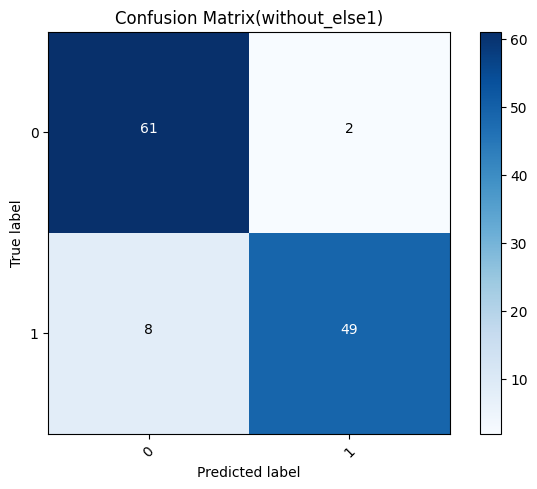

Accuracy on test set without band_delta: 0.9166666666666666


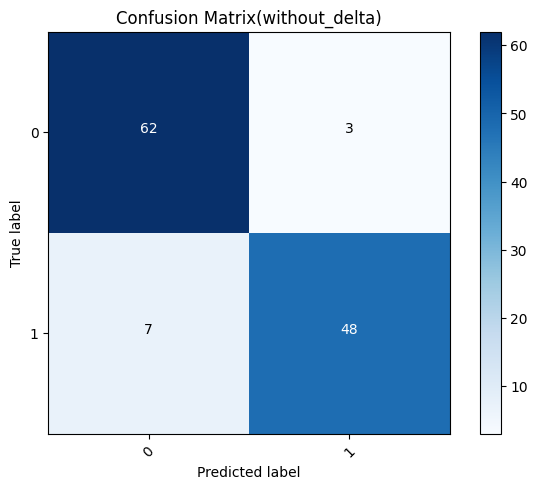

Accuracy on test set without band_theta: 0.9083333333333333


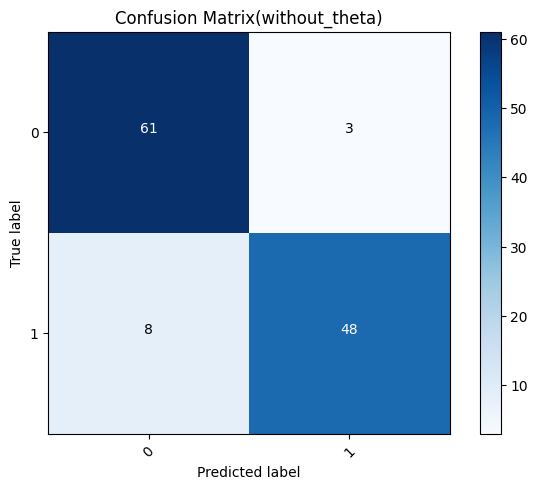

Accuracy on test set without band_alpha: 0.9166666666666666


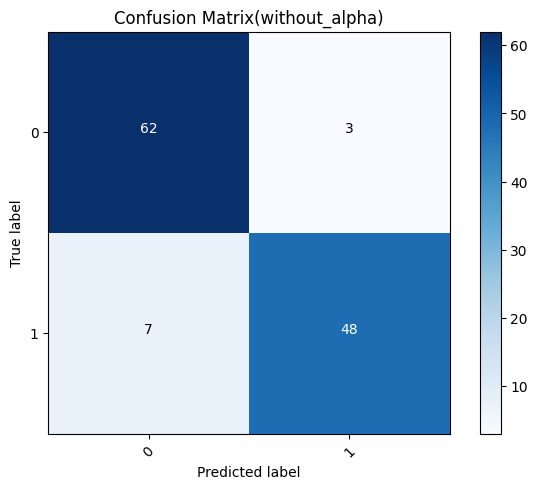

Accuracy on test set without band_beta: 0.9


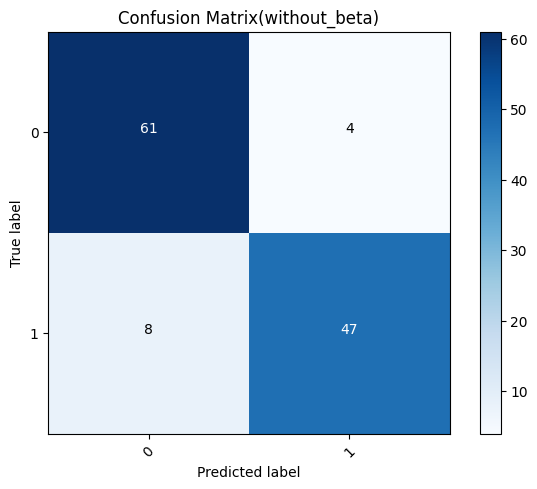

Accuracy on test set without band_gamma: 0.9166666666666666


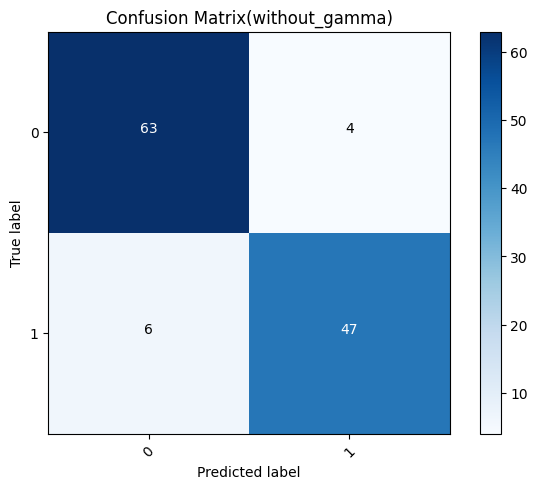

Accuracy on test set without band_high gamma: 0.9083333333333333


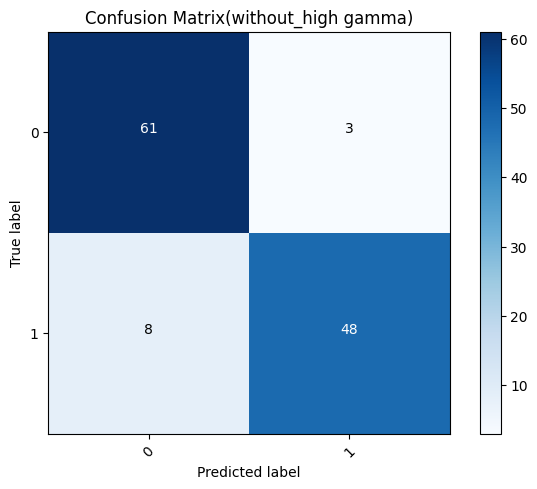

Accuracy on test set without band_else2: 0.925


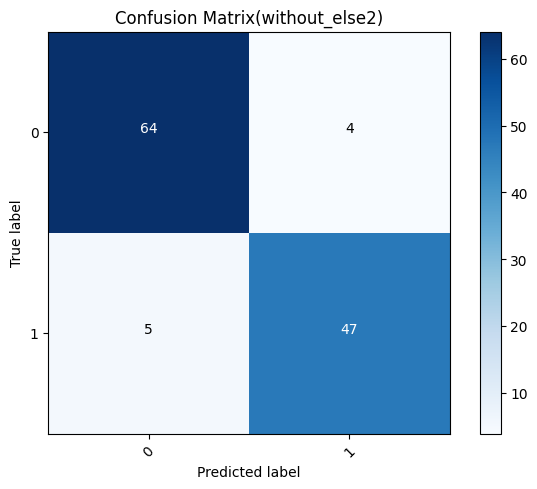

                  band  accuracy
0            all_bands  0.916667
1        without_else1  0.891667
2        without_else1  0.900000
3        without_delta  0.925000
4        without_theta  0.908333
5        without_else1  0.916667
6        without_delta  0.916667
7        without_theta  0.908333
8        without_alpha  0.916667
9         without_beta  0.900000
10       without_gamma  0.916667
11  without_high gamma  0.908333
12       without_else2  0.925000


In [5]:
band_list = get_all_band()
save_path = '/root/pp/covert-reading/Ecog_pretrain/binary_classify_results'

for band in band_list:
    data_loader = SVMDataset(HS, path_elec, freq, elec, num_samples, band)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=1/6, random_state=42)
    svm = RandomForestBinClassifier()
    svm.train(x_train=X_train, y_train=y_train)

    y_pred = svm.evaluate(X_test=X_test, y_test=y_test)
    band_acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy on test set without band_{band}: {band_acc}")

    metrics['band'].append(f'without_{band}')
    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    # plt confusion matrix
    plt_confusion_matric(y_test, y_pred, f'without_{band}')

# create DataFrame
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(os.path.join(save_path, 'acc_metrics_results.csv'), index=False)
print(metrics_df)

                  band  contribution
0        without_else1      0.025000
1        without_else1      0.025000
2        without_delta     -0.008333
3        without_theta      0.008333
4        without_else1      0.025000
5        without_delta     -0.008333
6        without_theta      0.008333
7        without_alpha      0.000000
8         without_beta      0.016667
9        without_gamma      0.000000
10  without_high gamma      0.008333
11       without_else2     -0.008333


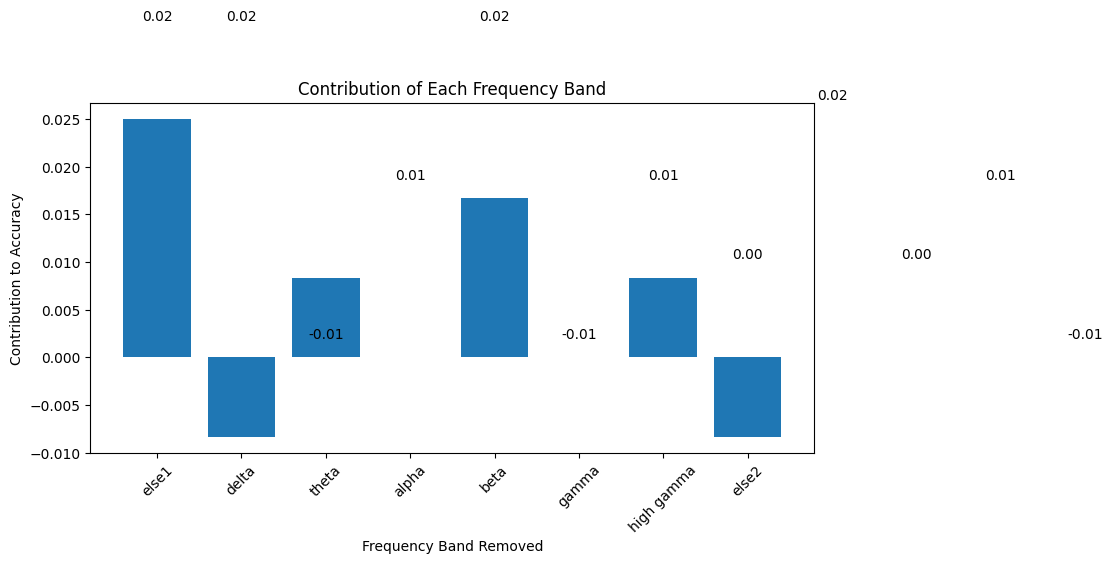

In [22]:
contribution_metrics = {'band': [], 'contribution': []}
baseline_accuracy = metrics_df.loc[metrics_df['band'] == f'all_bands', 'accuracy'].values[0]

for band in metrics_df['band']:
    # print(band)
    if band != 'all_bands':
        removed_band_accuracy = metrics_df.loc[metrics_df['band'] == f'{band}', 'accuracy'].values
        # print(removed_band_accuracy[0])
        if len(removed_band_accuracy) > 0:
            removed_band_accuracy = removed_band_accuracy[0]
            contribution = baseline_accuracy - removed_band_accuracy
            contribution_metrics['band'].append(f'{band}')
            contribution_metrics['contribution'].append(contribution)

contribution_df = pd.DataFrame(contribution_metrics)
contribution_df.to_csv(os.path.join(save_path, 'contribution_metrics_results.csv'), index=False)
print(contribution_df)
plt_contribution(contribution_df)